In [7]:
import numpy as np # import all libraries
import pandas as pd
import numpy as np
import sklearn as sk
from sklearn import preprocessing
import matplotlib.pyplot as plt
plt.rc("font", size = 14)
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report, auc, roc_auc_score, roc_curve, precision_recall_curve, precision_score,f1_score, recall_score, accuracy_score
import seaborn as sns
import os as os

path = '/Users/apple/Downloads/data/'
os.chdir(os.path.join(path))
os.getcwd()
# import data
loan_df = pd.read_csv('loan_approval_dataset.csv', sep = ',', skipinitialspace= True) # remove blank spaces from columns

## Gradient Boosting Classifier hyperparameters


In [2]:
print(loan_df.shape)

loan_df.rename(columns= lambda x: x.strip(), inplace= True) # remove spaces in the header
loan_df.columns = loan_df.columns.str.replace(' ', '')
num_cols = [col for col in loan_df.columns if loan_df[col].dtypes == 'int'] # list of numeric cols
cat_cols = [col for col in loan_df.columns if loan_df[col].dtypes == 'O'] # list of categorical cols
cat_cols.remove('loan_status')
print(num_cols)
print(cat_cols)
replace_vals = {'Approved': 1, 
                'Rejected': 0 }
loan_df.replace({'loan_status': replace_vals}, inplace= True) # replace loan status value with 0s & 1s
loan_df['loan_status'] = loan_df['loan_status'].astype(int)
y = pd.DataFrame(loan_df['loan_status'])
X = pd.DataFrame(loan_df.iloc[:, 0:12])

# train test split and reset index
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size= 0.2, random_state= 0)
X_train = X_train.reset_index(drop= True)
X_test = X_test.reset_index(drop= True)
y_train = y_train.reset_index(drop= True)
y_test = y_test.reset_index(drop= True)


# treat categorical variables
One_hot_Encoder = OneHotEncoder(categories= 'auto',
                                drop= 'first',
                                sparse= False)
One_hot_Encoder.fit(X_train[cat_cols])

X_train_transformed = pd.DataFrame(One_hot_Encoder.transform(X_train[cat_cols]))
X_test_transformed = pd.DataFrame(One_hot_Encoder.transform(X_test[cat_cols]))

X_train1 = pd.merge(X_train[num_cols], X_train_transformed, left_index= True, right_index= True)
X_test1 = pd.merge(X_test[num_cols], X_test_transformed, left_index= True, right_index= True)

# train and test data
print(X_train1.shape)
print(X_test1.shape)
print(y_train.shape)
print(y_test.shape)

(4269, 13)
['loan_id', 'no_of_dependents', 'income_annum', 'loan_amount', 'loan_term', 'cibil_score', 'residential_assets_value', 'commercial_assets_value', 'luxury_assets_value', 'bank_asset_value']
['education', 'self_employed']
(3415, 12)
(854, 12)
(3415, 1)
(854, 1)


In [8]:
from sklearn.ensemble import GradientBoostingClassifier
model = GradientBoostingClassifier()
model.fit(X_train1, y_train)
test_pred = model.predict(X_test1)
false_postive_rate, true_positive_ate, thresolds = roc_curve(y_test, test_pred) 
roc_auc = auc(false_postive_rate, true_positive_ate)
roc_auc

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


0.9865579130394597

## learning_rate
learning rate shrinks the contribution of each tree by learning_rate. high learning rate results in overfitting.

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/opt/anaco

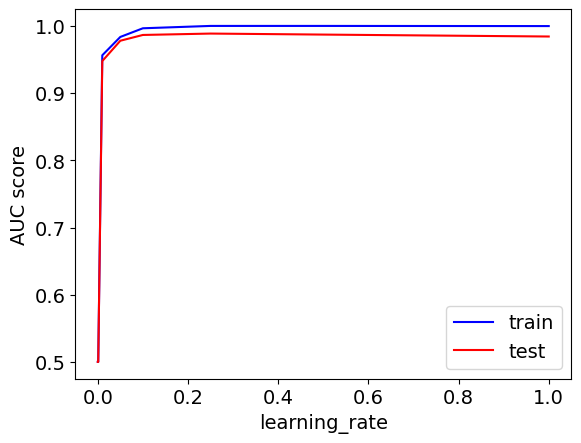

In [12]:
learning_rate = [1, 0.5, 0.25, 0.1, 0.05, 0.01, 0.001, 0.0001]
train_results = []
test_results = []

for rate in learning_rate:
    model = GradientBoostingClassifier(learning_rate=rate)
    model.fit(X_train1, y_train)
    train_pred = model.predict(X_train1)
    false_postive_rate, true_positive_ate, thresolds = roc_curve(y_train, train_pred) 
    roc_auc = auc(false_postive_rate, true_positive_ate)
    train_results.append(roc_auc)
    
    test_pred = model.predict(X_test1)
    false_postive_rate, true_positive_ate, thresolds = roc_curve(y_test, test_pred) 
    roc_auc = auc(false_postive_rate, true_positive_ate)
    test_results.append(roc_auc)
    
line1, = plt.plot(learning_rate, train_results, 'b', label= "Train AUC")
line2, = plt.plot(learning_rate, test_results, 'r', label= "Test AUC")
plt.legend(['train', 'test'], loc = "lower right")
plt.ylabel('AUC score')
plt.xlabel('learning_rate')
plt.show()

## N_estimators
n_estimators represents the number of trees in the forest. Usually the higher the number of trees the better to learn the data. However, adding a lot of trees can slow down the training process considerably, therefore we do a parameter search to find the sweet spot.
Increasing the number of estimators may result in overfitting also. In our case, using 10-15 trees is optimal.

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/opt/anaco

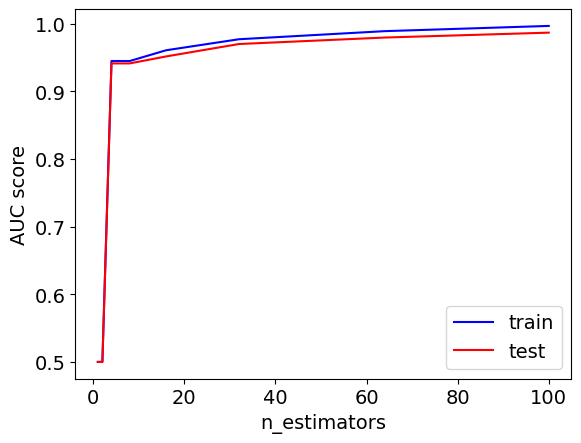

In [18]:
n_estimators = [1, 2, 4, 8, 16, 32, 64, 100]
train_results = []
test_results = []

for tree in n_estimators:
    model = GradientBoostingClassifier(n_estimators= tree)
    model.fit(X_train1, y_train)
    train_pred = model.predict(X_train1)
    false_postive_rate, true_positive_ate, thresolds = roc_curve(y_train, train_pred) 
    roc_auc = auc(false_postive_rate, true_positive_ate)
    train_results.append(roc_auc)
    
    test_pred = model.predict(X_test1)
    false_postive_rate, true_positive_ate, thresolds = roc_curve(y_test, test_pred) 
    roc_auc = auc(false_postive_rate, true_positive_ate)
    test_results.append(roc_auc)
    
line1, = plt.plot(n_estimators, train_results, 'b', label= "Train AUC")
line2, = plt.plot(n_estimators, test_results, 'r', label= "Test AUC")
plt.legend(['train', 'test'], loc = "lower right")
plt.ylabel('AUC score')
plt.xlabel('n_estimators')
plt.show()

## max_depth
max_depth. This indicates how deep the built tree can be. The deeper the tree, the more splits it has and it captures more information about how the data. We fit a decision tree with depths ranging from 1 to 32 and plot the training and test errors.

We see that our model overfits for large depth values. The tree perfectly predicts all of the train data, however, it fails to generalize the findings for new data

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/opt/anaco

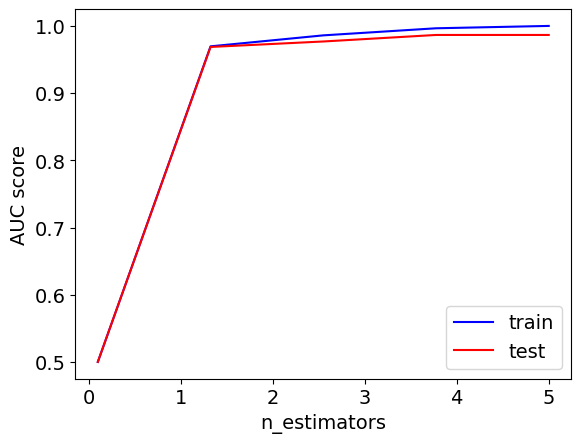

In [23]:
max_depth = np.linspace(0.1, 5, 5 ,endpoint=True)
train_results = []
test_results = []

for depth in max_depth:
    model = GradientBoostingClassifier(max_depth = depth)
    model.fit(X_train1, y_train)
    train_pred = model.predict(X_train1)
    false_postive_rate, true_positive_ate, thresolds = roc_curve(y_train, train_pred) 
    roc_auc = auc(false_postive_rate, true_positive_ate)
    train_results.append(roc_auc)
    
    test_pred = model.predict(X_test1)
    false_postive_rate, true_positive_ate, thresolds = roc_curve(y_test, test_pred) 
    roc_auc = auc(false_postive_rate, true_positive_ate)
    test_results.append(roc_auc)
    
line1, = plt.plot(max_depth, train_results, 'b', label= "Train AUC")
line2, = plt.plot(max_depth, test_results, 'r', label= "Test AUC")
plt.legend(['train', 'test'], loc = "lower right")
plt.ylabel('AUC score')
plt.xlabel('n_estimators')
plt.show()

## min_samples_split
min_samples_split represents the minimum number of samples required to split an internal node. This can vary between considering at least one sample at each node to considering all of the samples at each node. When we increase this parameter, the tree becomes more constrained as it has to consider more samples at each node. Here we will vary the parameter from 10% to 100% of the samples. min_sample_split introduces bias in the model.

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/opt/anaco

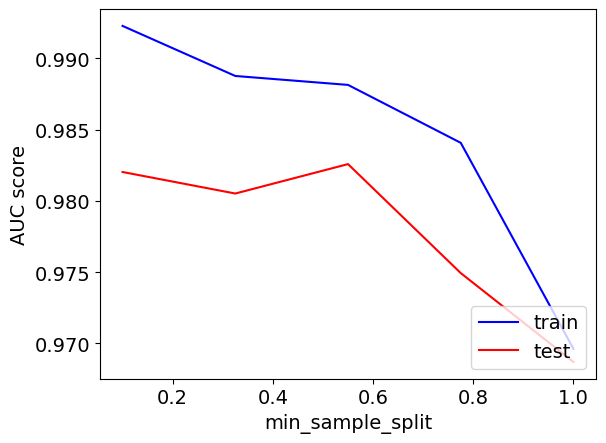

In [26]:
min_sample_split = np.linspace(0.1, 1.0, 5 ,endpoint=True)
train_results = []
test_results = []

for sample in min_sample_split:
    model = GradientBoostingClassifier(min_samples_split=  sample)
    model.fit(X_train1, y_train)
    train_pred = model.predict(X_train1)
    false_postive_rate, true_positive_ate, thresolds = roc_curve(y_train, train_pred) 
    roc_auc = auc(false_postive_rate, true_positive_ate)
    train_results.append(roc_auc)
    
    test_pred = model.predict(X_test1)
    false_postive_rate, true_positive_ate, thresolds = roc_curve(y_test, test_pred) 
    roc_auc = auc(false_postive_rate, true_positive_ate)
    test_results.append(roc_auc)
    
line1, = plt.plot(min_sample_split, train_results, 'b', label= "Train AUC")
line2, = plt.plot(min_sample_split, test_results, 'r', label= "Test AUC")
plt.legend(['train', 'test'], loc = "lower right")
plt.ylabel('AUC score')
plt.xlabel('min_sample_split')
plt.show()

## min_samples_leaf
min_samples_leaf is The minimum number of samples required to be at a leaf node. This similar to min_samples_splits, however, this describe the minimum number of samples of samples at the leafs.

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/opt/anaco

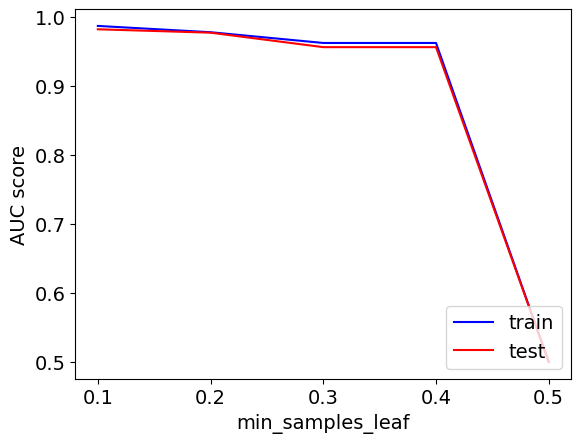

In [28]:
min_samples_leaf = np.linspace(0.1, 0.5, 5 ,endpoint=True)
train_results = []
test_results = []

for sample in min_samples_leaf:
    model = GradientBoostingClassifier(min_samples_leaf=  sample)
    model.fit(X_train1, y_train)
    train_pred = model.predict(X_train1)
    false_postive_rate, true_positive_ate, thresolds = roc_curve(y_train, train_pred) 
    roc_auc = auc(false_postive_rate, true_positive_ate)
    train_results.append(roc_auc)
    
    test_pred = model.predict(X_test1)
    false_postive_rate, true_positive_ate, thresolds = roc_curve(y_test, test_pred) 
    roc_auc = auc(false_postive_rate, true_positive_ate)
    test_results.append(roc_auc)
    
line1, = plt.plot(min_samples_leaf, train_results, 'b', label= "Train AUC")
line2, = plt.plot(min_samples_leaf, test_results, 'r', label= "Test AUC")
plt.legend(['train', 'test'], loc = "lower right")
plt.ylabel('AUC score')
plt.xlabel('min_samples_leaf')
plt.show()

## max_features
max_features represents the number of features to consider when looking for the best split. tweaking max_features can balance between bias and variance.

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/opt/anaco

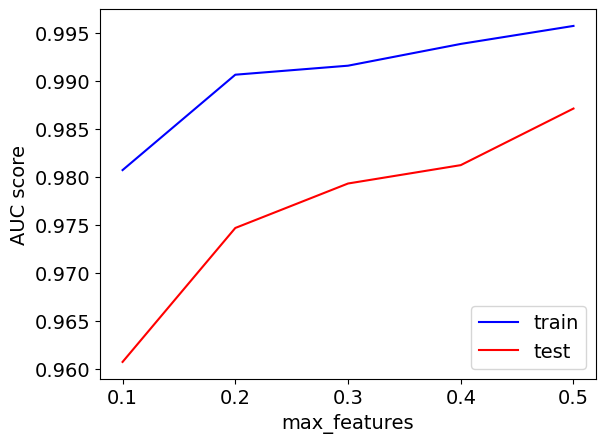

In [29]:
max_features = np.linspace(0.1, 0.5, 5 ,endpoint=True)
train_results = []
test_results = []

for feature in min_samples_leaf:
    model = GradientBoostingClassifier(max_features =  feature)
    model.fit(X_train1, y_train)
    train_pred = model.predict(X_train1)
    false_postive_rate, true_positive_ate, thresolds = roc_curve(y_train, train_pred) 
    roc_auc = auc(false_postive_rate, true_positive_ate)
    train_results.append(roc_auc)
    
    test_pred = model.predict(X_test1)
    false_postive_rate, true_positive_ate, thresolds = roc_curve(y_test, test_pred) 
    roc_auc = auc(false_postive_rate, true_positive_ate)
    test_results.append(roc_auc)
    
line1, = plt.plot(max_features, train_results, 'b', label= "Train AUC")
line2, = plt.plot(max_features, test_results, 'r', label= "Test AUC")
plt.legend(['train', 'test'], loc = "lower right")
plt.ylabel('AUC score')
plt.xlabel('max_features')
plt.show()

Index([                 'loan_id',         'no_of_dependents',
                   'income_annum',              'loan_amount',
                      'loan_term',              'cibil_score',
       'residential_assets_value',  'commercial_assets_value',
            'luxury_assets_value',         'bank_asset_value',
                                0,                          1],
      dtype='object')


# Ada Boost classifier

In [33]:
from sklearn.ensemble import AdaBoostClassifier
model = AdaBoostClassifier()
model.fit(X_train1, y_train)
test_pred = model.predict(X_test1)
false_postive_rate, true_positive_ate, thresolds = roc_curve(y_test, test_pred) 
roc_auc = auc(false_postive_rate, true_positive_ate)
roc_auc

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


0.9672266092090138

## N_estimators
n_estimators represents the number of trees in the forest. Usually the higher the number of trees the better to learn the data. However, adding a lot of trees can slow down the training process considerably, therefore we do a parameter search to find the sweet spot.


/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/opt/a

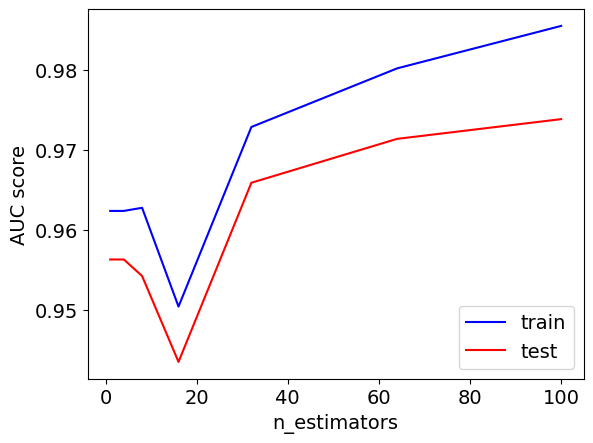

In [34]:
n_estimators = [1, 2, 4, 8, 16, 32, 64, 100]
train_results = []
test_results = []

for tree in n_estimators:
    model = AdaBoostClassifier(n_estimators= tree)
    model.fit(X_train1, y_train)
    train_pred = model.predict(X_train1)
    false_postive_rate, true_positive_ate, thresolds = roc_curve(y_train, train_pred) 
    roc_auc = auc(false_postive_rate, true_positive_ate)
    train_results.append(roc_auc)
    
    test_pred = model.predict(X_test1)
    false_postive_rate, true_positive_ate, thresolds = roc_curve(y_test, test_pred) 
    roc_auc = auc(false_postive_rate, true_positive_ate)
    test_results.append(roc_auc)
    
line1, = plt.plot(n_estimators, train_results, 'b', label= "Train AUC")
line2, = plt.plot(n_estimators, test_results, 'r', label= "Test AUC")
plt.legend(['train', 'test'], loc = "lower right")
plt.ylabel('AUC score')
plt.xlabel('n_estimators')
plt.show()

## learning_rate
learning rate shrinks the contribution of each tree by learning_rate. high learning rate results in overfitting.

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/opt/a

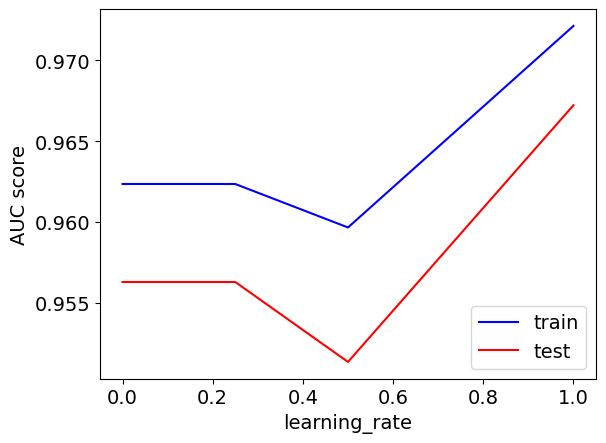

In [35]:
learning_rate = [1, 0.5, 0.25, 0.1, 0.05, 0.01, 0.001, 0.0001]
train_results = []
test_results = []

for rate in learning_rate:
    model = AdaBoostClassifier(learning_rate=rate)
    model.fit(X_train1, y_train)
    train_pred = model.predict(X_train1)
    false_postive_rate, true_positive_ate, thresolds = roc_curve(y_train, train_pred) 
    roc_auc = auc(false_postive_rate, true_positive_ate)
    train_results.append(roc_auc)
    
    test_pred = model.predict(X_test1)
    false_postive_rate, true_positive_ate, thresolds = roc_curve(y_test, test_pred) 
    roc_auc = auc(false_postive_rate, true_positive_ate)
    test_results.append(roc_auc)
    
line1, = plt.plot(learning_rate, train_results, 'b', label= "Train AUC")
line2, = plt.plot(learning_rate, test_results, 'r', label= "Test AUC")
plt.legend(['train', 'test'], loc = "lower right")
plt.ylabel('AUC score')
plt.xlabel('learning_rate')
plt.show()